In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs 
from sklearn import svm

from h import *
from W_unitary import *
from U_unitary import *
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10,6)
#plt.rcParams['figure.dpi'] = 100
#sns.set()

<ipython-input-1-54619f893b08>:14: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD


In [2]:
def make_meshgrid(x1, x2, h=0.2):
    
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    return x1x1, x2x2


def plot_contours(ax, classifier, x1x1, x2x2, **params):

    contours = classifier.predict(np.c_[x1x1.ravel(), x2x2.ravel()])
    contours = contours.reshape(x1x1.shape)

    return ax.contourf(x1x1, x2x2, contours, **params)

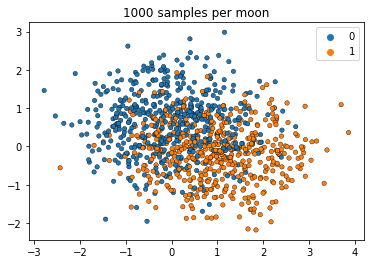

In [3]:
n_samples = 1000
X, y = make_moons(n_samples=n_samples, noise=0.7)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=20, edgecolor="k", legend=True).set_title(str(n_samples) +" samples per moon")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
classical_svm = svm.LinearSVC()
classical_svm.fit(X_train, y_train)

LinearSVC()

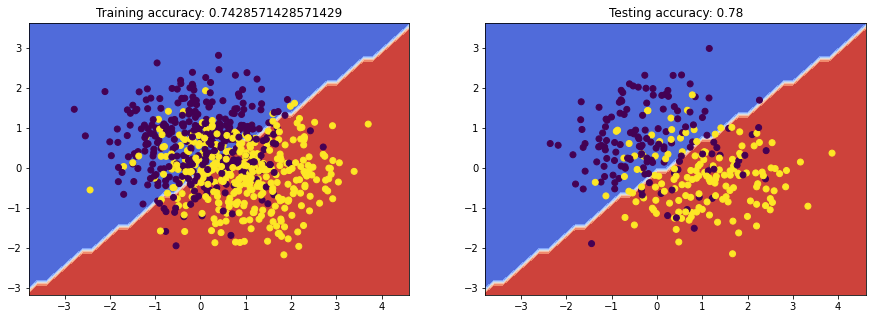

In [5]:
accuracy_train = classical_svm.score(X_train, y_train)
accuracy_test = classical_svm.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x1x1, x2x2 = make_meshgrid(X_0, X_1)
contours = classical_svm.predict(np.c_[x1x1.ravel(), x2x2.ravel()])
contours = contours.reshape(x1x1.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x1x1, x2x2, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x1x1, x2x2, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

In [6]:
gaussian_kernel = svm.SVC(gamma = 'scale')
gaussian_kernel.fit(X_train, y_train);

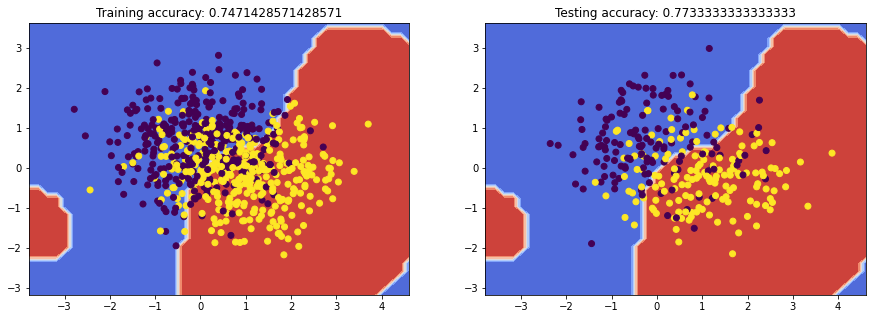

In [7]:
accuracy_train = gaussian_kernel.score(X_train, y_train)
accuracy_test = gaussian_kernel.score(X_test, y_test)


X_0, X_1 = X_train[:, 0], X_train[:, 1]
x1x1, x2x2 = make_meshgrid(X_0, X_1)
contours = gaussian_kernel.predict(np.c_[x1x1.ravel(), x2x2.ravel()])
contours = contours.reshape(x1x1.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x1x1, x2x2, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x1x1, x2x2, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

In [8]:
RANDOM_STATE = 42
seed = np.random.seed(RANDOM_STATE)

n = 2
d = 2

Theta = 2*np.pi*np.random.random(n*d*3)
print(Theta)

[2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]


In [9]:
shots=1024
predictions = []
for i in range(0, len(y_train)):
    predictions.append(h(X_train[i], Theta, n, d, shots))
print(predictions)

MissingOptionalLibraryError: "The 'qiskit-aer' library is required to use 'Aer provider'. You can install it with 'pip install qiskit-aer'."

In [ ]:
def MSE_loss(Theta, y_train):
    
    new_y_train = []
    for i in range(0, len(y_train)):
        if y_train[i] == 0:
            new_y_train.append(-1)
        else:
            new_y_train.append(1)
    
    #shots=1024
    predictions = []
    for i in range(0, len(y_train)):
        predictions.append(h(X_train[i], Theta, n, d, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - new_y_train[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    return norm

In [ ]:
#Determine the optimal parameters
objective_function = lambda Theta: MSE_loss(Theta, y_train)

optimizer = COBYLA(maxiter=100)
Theta_opt = optimizer.minimize(objective_function, Theta).x

In [ ]:
h_new = []
for i in range(0, len(y_train)):
    h_new.append(h(X_train[i], Theta_opt, n, d, shots))

In [ ]:
print(sum(2*y_train-1-h_new))
print(sum(2*y_train-1-predictions))

In [ ]:
h_test = []
for i in range(0, len(y_test)):
    h_test.append(h(X_test[i], Theta_opt, n, d, shots))

print(sum(2*y_test-1-h_test))
print(len(y_test))